# Mackey-Glass autoregression

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import water_tank as wt

The Mackey-Glass equations are delay differential equations that exhibit chaotic behavior, i.e. they cannot be predict accurately for a long period of time.

$$\frac{d x(t)}{dt} = \beta \, \frac{x(t - \tau)}{1 + x(t - \tau)^n} - \gamma \, x(t)$$

To check this, we use `reservoirpy` (<https://reservoirpy.readthedocs.io>) to generate two time series with very close initial conditions ($\epsilon = 10^{-6}$). After roughly two seconds of simulation, the two time series start to diverge.

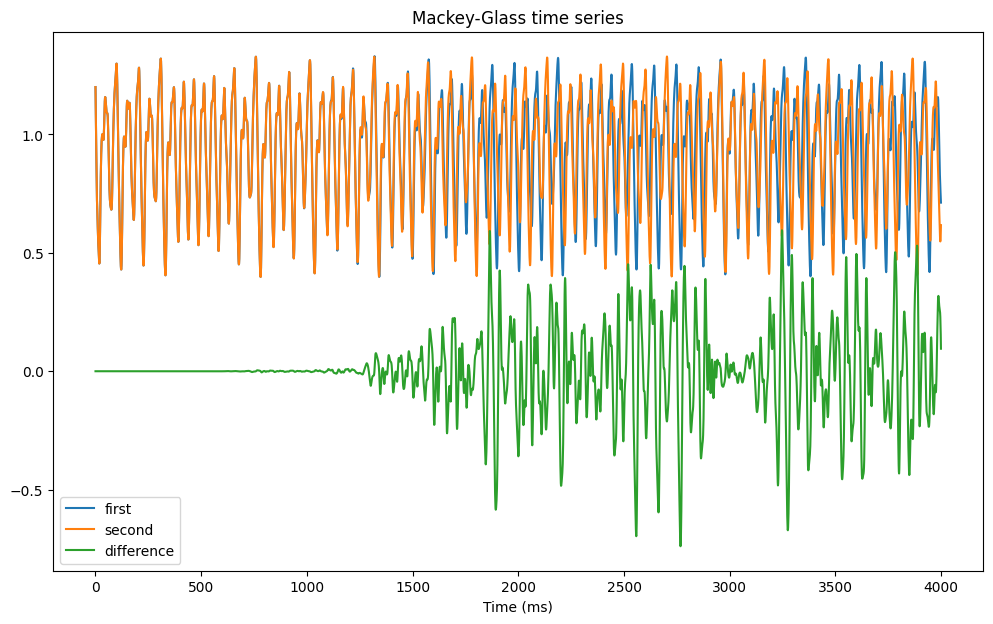

In [22]:
from reservoirpy.datasets import mackey_glass

mg1 = mackey_glass(4000, x0=1.2)
mg2 = mackey_glass(4000, x0=1.2 + 1e-6)

plt.figure(figsize=(12, 7))
plt.plot(mg1, label="first")
plt.plot(mg2, label="second")
plt.plot(mg1 - mg2, label="difference")
plt.legend()
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

For the autoregression task, we generate a time series, normalize it and create supervised targets to predict the value of the signal at time $t + 1$ given the past. 

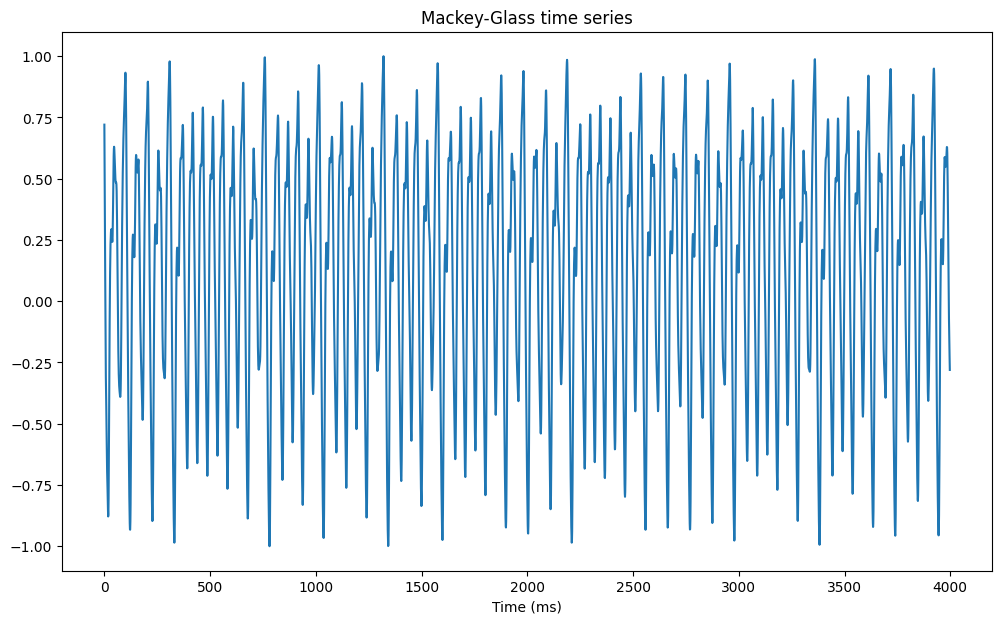

In [23]:
# Generate time series
mg = mackey_glass(4000, x0=1.2)

# Normalize between -1 and 1
mg =  2.0 * (mg - mg.min()) / (mg.max() - mg.min()) - 1.0

# The task is to predict the next value
X = mg[:-1, 0]
Y = mg[1:, 0]

plt.figure(figsize=(12, 7))
plt.plot(X)
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

We now create an echo-state network with:

* an input layer with one neuron
* a reservoir with $N$ tanh neurons.
* a readout layer with one neuron.

The weight matrices are initialized classically. Note that the recurrent and readout neurons both use biases. The readout weights are trained online using the **recursive least squares** (RLS) method. 

Two methods are implemented in the class: a training method calling the learning rule, and an autoregressive method plugging the output of the networks back into its input. 

In [24]:
class ESN(object):

    def __init__(self, N, N_in, N_out, g, tau, sparseness):

        # Input population
        self.inp = wt.StaticInput(size=N_in)

        # Reservoir 
        self.rc = wt.RecurrentLayer(size=N, tau=tau)

        # Readout
        self.readout = wt.LinearReadout(size=N_out)

        # Input projection
        self.inp_proj = wt.connect(
            pre = self.inp, 
            post = self.rc, 
            weights = wt.Bernouilli([-1.0, 1.0], p=0.5), 
            bias = None,
            sparseness = 0.1
        )

        # Recurrent projection
        self.rec_proj = wt.connect(
            pre = self.rc, 
            post = self.rc, 
            weights = wt.Normal(0.0, g/np.sqrt(sparseness*N)), 
            bias = wt.Bernouilli([-1.0, 1.0], p=0.5), # very important
            sparseness = sparseness
        )

        # Readout projection
        self.readout_proj = wt.connect(
            pre = self.rc, 
            post = self.readout,
            weights = wt.Const(0.0),
            bias = wt.Const(0.0), # learnable bias
            sparseness = 1.0 # readout should be dense
        )

        # Learning rules
        self.learningrule = wt.RLS(projection=self.readout_proj, delta=1e-6)

        # Recorder
        self.recorder = wt.Recorder()

    @wt.measure
    def train(self, X, Y, warmup=0):

        for t, (x, y) in enumerate(zip(X, Y)): 

            # Inputs/targets
            self.inp.set(x)

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Learning
            if t >= warmup: self.learningrule.train(error=y - self.readout.output())

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output(),
            })
    
    @wt.measure
    def autoregressive(self, duration):

        for _ in range(duration): 
            # Autoregressive input
            self.inp.set(self.readout.output())  

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output()
            })

In [25]:
N_in = 1 # number of inputs
N_out = 1 # number of outputs
N = 200 # number of neurons
g = 1.25 # scaling factor
tau = 3.3 # time constant
sparseness = 0.1 # sparseness of the recurrent weights

net = ESN(N, N_in, N_out, g, tau, sparseness)

We train the reservoir for 500 time steps and let it predict the signal autoregressively for 1000 steps.

In [26]:
# Training / test
d_train = 500
d_test = 1000

# Supervised training
net.train(X[:d_train], Y[:d_train], warmup=0)

# Autoregressive test
net.autoregressive(duration=d_test)

data = net.recorder.get()

Execution time: 269 ms
Execution time: 25 ms


The training error becomes quickly very small. When predicting the time series autoregressively, the predictions are precise for around 200 steps, before starting to diverge. 

/var/folders/6w/6msx49ws7k13cc0bbys0tt4m0000gn/T/ipykernel_23790/287914352.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


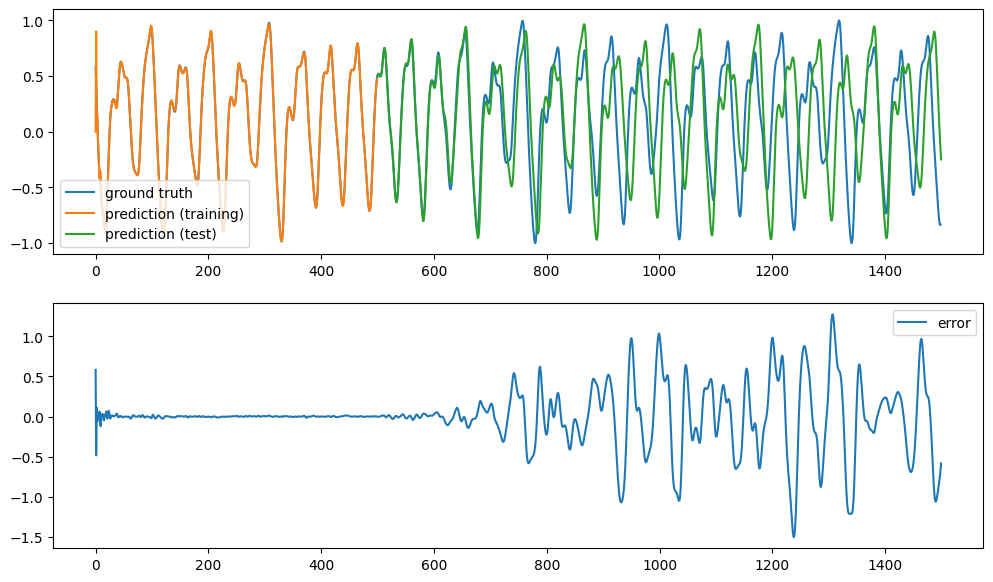

In [27]:
plt.figure(figsize=(12, 7))
plt.title("Autoregression")
plt.subplot(211)
plt.plot(Y[:d_train+d_test], label='ground truth')
plt.plot(data['readout'][:d_train, 0], label='prediction (training)')
plt.plot(np.linspace(d_train, d_train+d_test, d_test), data['readout'][d_train:, 0], label='prediction (test)')
plt.legend()
plt.subplot(212)
plt.plot(Y[:d_train+d_test] - data['readout'][:, 0], label='error')
plt.legend()
plt.show()

It is interesting to note that, for the autoregression to work correctly, the input biases are critical. They have the effect that many reservoir neurons are saturated (+1 or -1) and only a few are in the "useful" region and change their sign.

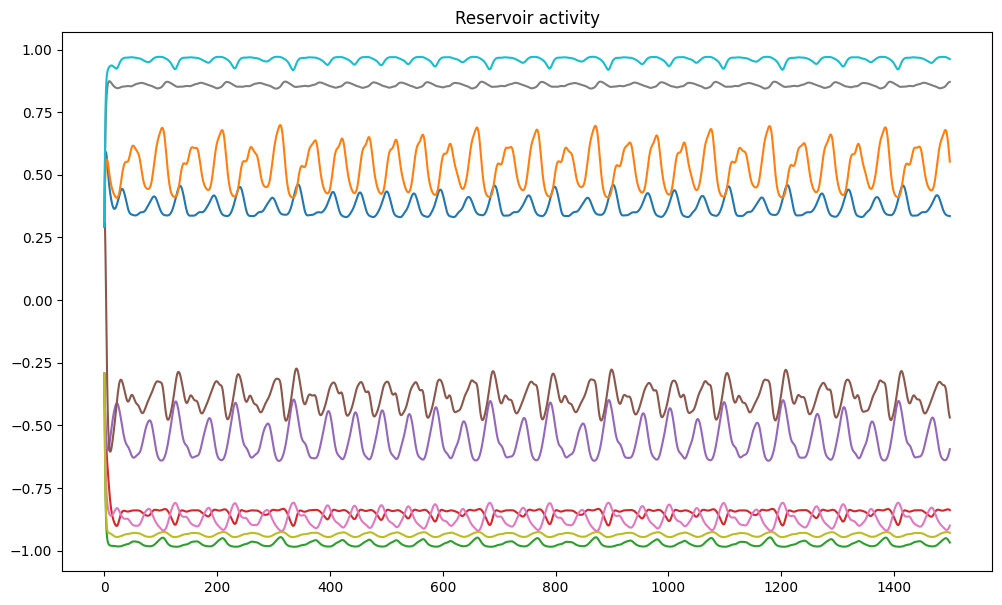

In [28]:
plt.figure(figsize=(12, 7))
plt.title("Reservoir activity")
for i in range(10):
    plt.plot(data['rc'][:, i])
plt.show()

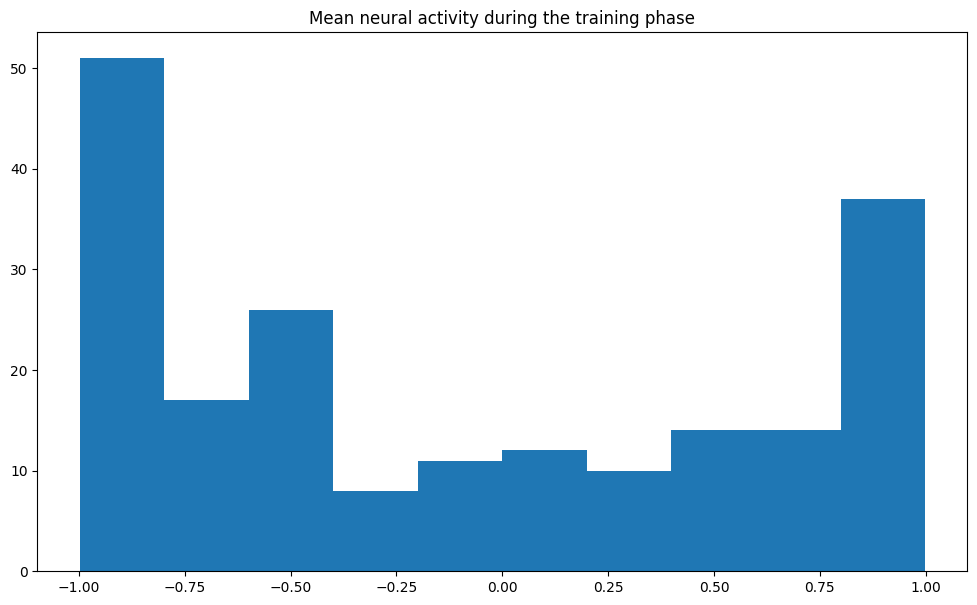

In [29]:
mean_act = data['rc'].mean(axis=0)

plt.figure(figsize=(12, 7))
plt.title("Mean neural activity during the training phase")
plt.hist(mean_act)
plt.show()

When plotting the readout weights after training, we can see that saturated neurons whose activity is very close to +1 or -1 throughout learning tend to get smaller readout weights. This is an effect of the inverse correlation matrix used in RLS: if the pre neuron is not significantly active, it should not participate to the output. 

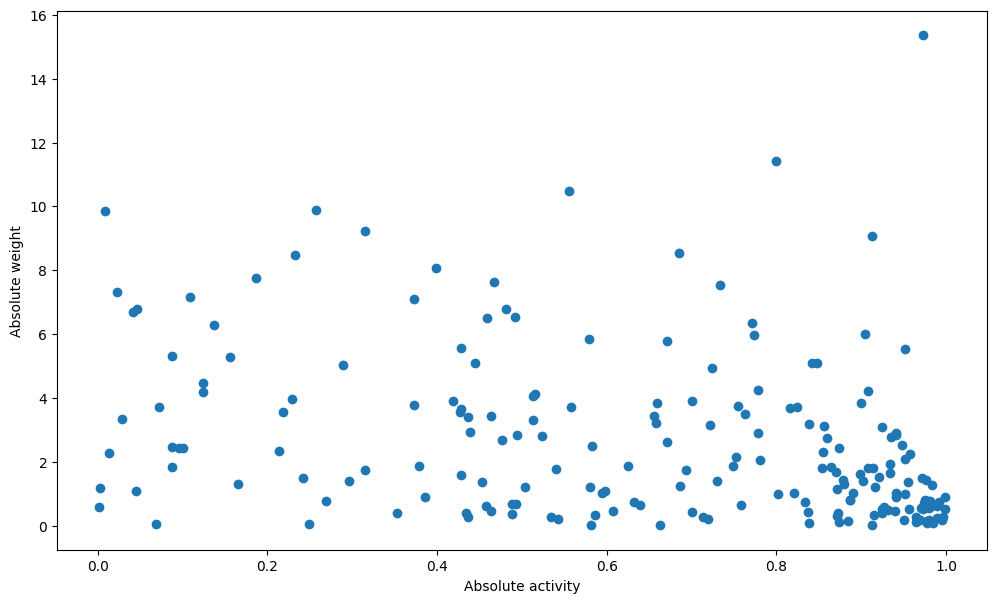

In [30]:
plt.figure(figsize=(12, 7))
plt.scatter(np.abs(mean_act), np.abs(net.readout_proj.W[0, :]))
plt.xlabel("Absolute activity")
plt.ylabel("Absolute weight")
plt.show()